### Imports

In [2]:
import zipfile
import glob
import cv2
import os
from scipy import misc

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Conv2D, GlobalAveragePooling2D
import tqdm
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import numpy as np
import mahotas as mh
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def load_stack(imgdir, alphanum=False):
    files = list(sorted(glob.glob(os.path.join(imgdir, '*.png'))))
    
    st = []
    for i in tqdm(range(len(files))):
        ff = imgdir + '/' + str(i) + '.png' 
        if not alphanum: ff=files[i]
        input_img = misc.imread(ff)
        if len(input_img.shape)>2: input_img = input_img[:,:,0]
        input_img = input_img.astype(float)/255.
        testinp = input_img.reshape(input_img.shape[0],input_img.shape[1], 1)
        st.append(testinp)
    return np.array(st)

In [6]:
imgs_train = load_stack('epfl_train')

  0%|          | 0/165 [00:00<?, ?it/s]/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
100%|██████████| 165/165 [00:02<00:00, 77.65it/s]


In [7]:
imgs_mask_train = load_stack('epfl_train_gt')

  0%|          | 0/165 [00:00<?, ?it/s]/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
100%|██████████| 165/165 [00:01<00:00, 160.70it/s]


In [8]:
imgs_test = load_stack('epfl_test')

  0%|          | 0/165 [00:00<?, ?it/s]/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
100%|██████████| 165/165 [00:02<00:00, 78.51it/s]


In [9]:
imgs_mask_test = load_stack('epfl_test_gt')

  0%|          | 0/165 [00:00<?, ?it/s]/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
100%|██████████| 165/165 [00:01<00:00, 160.75it/s]


### Generate Data

In [10]:
def get_bounds(img):
    fig1 = plt.figure(figsize=(10,10))
    ax1 = fig1.add_subplot(111, aspect='equal')
    plt.imshow(img, cmap='gray')
    res, num = mh.label(img)
    for i in range(1, num):
        kvla = np.where(res==i)
        x_min = np.min(kvla[0])
        x_max = np.max(kvla[0])
        y_min = np.min(kvla[1])
        y_max = np.max(kvla[1])
        
        print(x_min, x_max, y_min, y_max)
        
def sample(imgs, imgs_raw, odir_pos, odir_neg, num_pos, num_neg):
    if not odir_pos.endswith('/'):
        odir_pos = odir_pos + '/'
    if not odir_neg.endswith('/'):
        odir_neg = odir_neg + '/'
        
    while(True): #select random training image
        randindex = np.random.randint(0, imgs.shape[0])
        img = imgs[randindex]
        img_raw = imgs_raw[randindex]

        size = 128
        x_crop = np.random.randint(0, img.shape[0]-size)
        y_crop = np.random.randint(0, img.shape[1]-size)
        
        crop = img[x_crop:(x_crop+size), y_crop:(y_crop+size)]
        crop_raw = img_raw[x_crop:(x_crop+size), y_crop:(y_crop+size)]
        if np.sum(crop==1)>0.1*(crop.shape[0]*crop.shape[1]): #positive
            if num_pos>0:
                num_pos-=1
                cv2.imwrite(odir_pos + str(num_pos) + '.png', crop_raw*255.)
        else:
            if num_neg>0:
                num_neg-=1
                cv2.imwrite(odir_neg + str(num_neg) + '.png', crop_raw*255.)
                
        if num_pos==0 and num_neg==0: break

In [11]:
sample(imgs_mask_train,imgs_train,'samples_train/0', 'samples_train/1',1000,1000)

In [12]:
sample(imgs_mask_test,imgs_test,'samples_test/0', 'samples_test/1',1000,1000)

In [29]:
def get_model(img_shape):
    # Block 1
    img_input = Input(shape=img_shape)
    start_filters = 8
    x = Conv2D(start_filters, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(start_filters, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(start_filters*2, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(start_filters*2, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(start_filters*4, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(start_filters*4, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(start_filters*4, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(start_filters*8, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(start_filters*8, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(start_filters*8, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(start_filters*8, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(start_filters*8, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(start_filters*8, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    
    x = GlobalAveragePooling2D()(x)
    m = keras.Model(inputs=img_input, outputs = x)
    return m

In [30]:
model_bottom = get_model((128,128,1)) 

In [31]:
#we are interested in the intermediate output, so we stack the final model together just here.
model = Sequential()
for layers in model_bottom.layers:
    model.add(layers)
model.add(Dense(2, name='dense'))
model.add(Activation('softmax'))
model.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 8)       80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 8)       584       
_________________________________________________________________
block1_pool (AveragePooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 16)        1168      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 16)        2320      
_________________________________________________________________
block2_pool (AveragePooling2 (None, 32, 32, 16)        0         
__________

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) #, rescale=1/255.)

train_generator = datagen.flow_from_directory(
        'samples_train',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical', classes=['1','0'], color_mode='grayscale', shuffle=True) 
        
validation_generator = datagen.flow_from_directory(
        'samples_test',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical', classes=['1','0'], color_mode='grayscale')

model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50, validation_data = validation_generator, validation_steps=100)

In [37]:
def get_heatmap(model_intermediate, input_img, verbose=False):
    class_contributions = model.get_layer('dense').get_weights()[0] #(64, 1)
    intermediate = model_intermediate.predict(input_img)[0] #(8, 8, 64)
    
    if verbose:
        print('class_contributions', class_contributions.shape)
        print('intermediate', intermediate.shape)
    
    classmap = np.zeros(shape=(8,8))
    for i in range(class_contributions.shape[0]):
        classmap+=class_contributions[i,1]*intermediate[:,:,i]
    return classmap

In [38]:
intermediate_layer_model = keras.Sequential()
for l in model.layers:
    intermediate_layer_model.add(l)
    if l.name == 'block5_conv3':
        break

print(intermediate_layer_model.summary())

63 214
(1, 128, 128, 1)


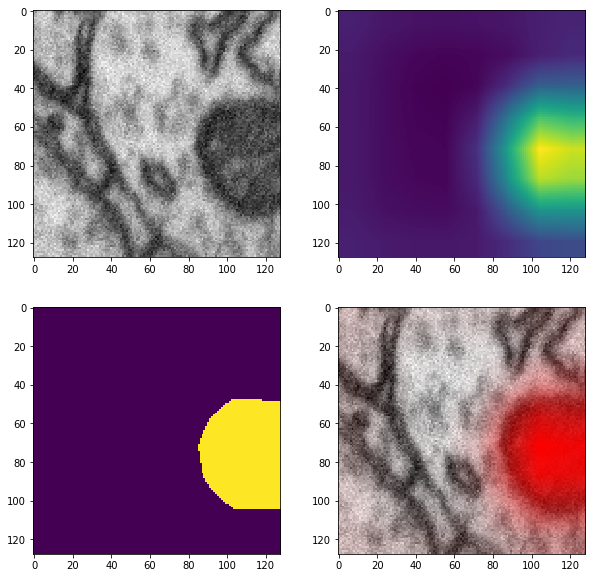

In [42]:
sample_input = cv2.imread('samples_train/0/91.png',0).reshape(1,128,128,1)
print(sample_input.min(), sample_input.max())
print(sample_input.shape)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
UPSAMPLE=True
t=0.5

heatmap = get_heatmap(intermediate_layer_model, sample_input)
plt.imshow(sample_input[0,:,:,0], cmap='gray')

if UPSAMPLE:
    heatmap = cv2.resize(heatmap, (128,128), cv2.INTER_LINEAR)

plt.subplot(2,2,2)
plt.imshow(heatmap)
heatmap_normalized = (heatmap.copy()-heatmap.min())/(heatmap.max()-heatmap.min())
heatmap_binarized = heatmap_normalized.copy()
heatmap_binarized[heatmap_binarized<t]=0
heatmap_binarized[heatmap_binarized>=t]=1
plt.subplot(2,2,3)
plt.imshow(heatmap_binarized)
plt.subplot(2,2,4)
plt.imshow(sample_input[0,:,:,0], cmap='gray')

overlay = np.zeros((128,128,4))
overlay[:,:,0] = 1
overlay[:,:,3] = cv2.resize(heatmap_normalized, (128,128), cv2.INTER_LINEAR)
r = plt.imshow(overlay)

### Test on Full Image

In [ ]:
offset=16
size_extract=256
perform_resize=True
selected_index = 0
selected = imgs_train[selected_index,:,:,0]
selected_gt = imgs_mask_train[selected_index,:,:,0]

total_sum = np.zeros_like(selected)
total_num = np.zeros_like(selected)
for x in range(0,selected.shape[0],offset):
    for y in range(0,selected.shape[1],offset):
        if x>=selected.shape[0]-size_extract:
            x=selected.shape[0]-size_extract
        if y>=selected.shape[1]-size_extract:
            y=selected.shape[1]-size_extract

        crop = selected[x:(x+size_extract), y:(y+size_extract)]
        if perform_resize:
            crop = cv2.resize(crop, (128,128))
        img_input = crop.reshape(1,128,128,1)*255.
        
        
        pred_class = model.predict(img_input)
        pred_class = float(pred_class[0][1])
        prediction = get_heatmap(intermediate_layer_model, img_input)
        
        prediction = cv2.resize(prediction,(size_extract,size_extract))
        
        total_sum[x:(x+size_extract), y:(y+size_extract)]+=prediction#*pred_class
        total_num[x:(x+size_extract), y:(y+size_extract)]+=1
        
total_sum/=total_num
plt.figure(figsize=(10,7))
plt.imshow(total_sum)
plt.figure(figsize=(10,7))
plt.imshow(selected_gt)